# Análisis de Datos III
## Exposición Artículo
### Prof. Maikol Solís
### Estudiante: Jimmy Calvo

### Implementación

## Artículo de Referencia

- Título: *Invariant optimal feature selection: a distance discriminant and feature ranking based solution*.
- Autores: **J. Liang, S. Yang, A. Winstanley**.
- Pattern Recognition 41 (2008) 1429–1439.
- <https://doi.org/10.1016/j.patcog.2007.10.018>.

En este artículo se introduce una métrica basada en un discriminante de distancias para ranquear variables numéricas con respecto a una variable de respuesta categórica. Los autores desarrollan una fórmula de discriminante que mide la variación intra e inter clase de los atributos del conjunto de datos y a partir de esta medición pueden obtener un criterio para cuantificar la relación de una variable con el atributo de respuesta.

Aquí implementamos la medida FSDD [Feature Selection by Distance Discriminant] descrita en el artículo de referencia. Este artículo compara este método con otros algoritmos para seleccionar variables, a saber: el algoritmo ReliefF y el algoritmo mrmrMID (minimum redundancy maximum relevancy MID selection). El algoritmo ReliefF se encuentra implementado en python, el mrmrMID no, pero hemos escrito su implementación acá. Usamos la biblioteca $\verb"sklearn.metrics"$ para calcular la métrica de información mutua en este caso.

Nota: Originalmente se planeaba exponer sobre el siguiente artículo:

- Título: *RFS: Efficient feature selection method based on R-value*.
- Autores: **Jimin Lee, Nomin Batnyam, Sejong Ohn**.
- **Computers in Biology and Medicine, Volume 43, Issue 2, February, 2013 pp 91–99**.
- <https://doi.org/10.1016/j.compbiomed.2012.11.010>.

En este se introduce la métrica R para ranquear importancia de variables en un problema de clasificación. Esta métrica se compara con las métricas Relief, mrmrMID y con el método FSDD. Luego me dí cuenta de que los conjuntos de datos utilizados en éste último artículo no se encuentran disponibles (son más que todo micro-array data), además para evitar la referencia de muchos artículos previos decidí utilizar el artículo de FSDD para la exposición. Por esta razón en este código el lector podrá encontrar implementaciones de la metrica R también.

In [1]:
#Basics
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import time
import statistics as stats
import pandas as pd
import numpy as np
from numpy import linalg as LA

#Bibliotecas para reliefF y Mutual Information
import sklearn_relief as sr #Opción 1 para ReliefF
from skrebate import ReliefF #Opción 2 para ReliefF
from sklearn.metrics import mutual_info_score

#Clasificadores de sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
#Importante: en muchos casos hay que normalizar los datos.
from sklearn.preprocessing import MinMaxScaler

#Cálculo de precisión usando CV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
#from sklearn.metrics import accuracy_score

#### Implementación de FSDD

In [2]:
def fsdd(df, colname, respname, beta):
    
    """
    Regresa la métrica FSDD para una variable descrita en el artículo de referencia.
    
    Los atributos son:
    
    df: dataframe a utilizar.
    colname: nombre de la columna en el dataframe a la cual queremos calcularle el valor fsdd.
    resp: nombre de la columna en el dataframe que contiene la variable de respuesta.
    beta: factor de control sobre la variación inter-clases del algoritmo.
    
    """
    
    #Guardamos ambos vectores como listas.
    col= list(df[colname]) 
    resp= list(df[respname])
    resp_unique = list(set(resp)) #Valores únicos de las clases
    priors=[resp.count(a)/len(resp) for a in resp_unique] #Cálculo de vectores de probabilidades anteriores (prior)
    
    ##Primero: cálculo de la varianza de la columna o atributo en cuestión.
    mean_col = (1/len(col))* sum([a for a in col])
    sigma_k_squared= (1/len(col))* sum([(a- mean_col)**2 for a in col])
    
    ##Luego: varianza de este atributo en las observaciones que corresponden a cada clase. Esto es el sigma_k(i)^2 de la literatura.
    sigma_k_clase=[0]*len(resp_unique)
    for i in range(0,len(resp_unique)):
        #Observaciones en la clase i-ésima en la columna de interés
        obs_clase=[col[j] for j in range(0,len(col)) if resp[j] == resp_unique[i]]
        mean_obs_clase= (1/len(obs_clase))*sum([a for a in obs_clase])
        sigma_k_clase[i]=(1/(len(obs_clase)-1))*sum([(a-mean_obs_clase)**2 for a in obs_clase])
    
    ##Seguidamente hay que regresar el sigma_k''^2:
    ##es la varianza promediada del centroide de la clase i-ésima en la variable en cuestión
    centroide_clase=[0]*len(resp_unique)
    for i in range(0,len(resp_unique)):
                          
        #Observaciones en la clase i-ésima.
        obs_clase=[col[j] for j in range(0,len(col)) if resp[j] == resp_unique[i]]
        #centroide_clase[i]=np.mean(obs_clase) #Esto es el m_i^k de la literatura
        centroide_clase[i]=(1/len(obs_clase))*sum([a for a in obs_clase])
                          
    m_k= sum([priors[i]*centroide_clase[i] for i in range(0,len(resp_unique))])
    sigma_k_pp= sum([priors[i]*(centroide_clase[i] - m_k)**2 for i in range(0,len(resp_unique))])
    
    FSDD= (1/sigma_k_squared)*(sigma_k_pp - beta*sum([priors[i]*sigma_k_clase[i] for i in range(0,len(resp_unique))]))
    return FSDD

#### Implementación del valor R

In [3]:
def r_value(df,colname,respname,k,theta):
    
    """
    Regresa el valor R de una variable con respecto a la respuesta. Basado en el pseudo-código escrito en la página 93 del artículo
    de referencia sobre el valor R (el arículo de Jimin Lee, Nomin Batnyam, Sejong Ohn).
    
    Atributos:
    
    df: dataframe a utilizar.
    colname: nombre de la columna en el dataframe a la cual queremos calcularle el valor fsdd.
    resp: nombre de la columna en el dataframe que contiene la variable de respuesta.
    k: número de vecinos más cercanos a tomar en la variable en cuestión.
    theta es un 'threshold value' para calcular el tralsape.
    
    """
    
    #Guardamos ambos vectores como listas.
    col= list(df[colname]) 
    resp= list(df[respname])
    N=len(col) #Número de observaciones.
    traslape=[0]*N #vector en el que se guarda si una observación está en un área de traslape o no.
    
    #Ordenar el vector col.
    #Mantener la correspondencia en el vector resp.
    #Se puede hacer en una línea con el comando zip.
    col, resp = zip(*sorted(zip(col, resp)))
    
    for i in range(0,N):
        #Hay que contar el número de vecinos cercanos a col[i]
        #que tienen la misma clase que col[i]
        #Para ello guardamos las clases de estos vecinos.
        #Como col[i] y resp[i] están ordenados respectivamente esto es sencillo
        clases_vecinos_i= resp[max(i-k,0):(min(i+k,N)+1)]
        X = sum([1 if a==resp[i] else 0 for a in clases_vecinos_i])
        
        if (X/k>=theta):
            traslape[i]=1
        else:
            traslape[i]=0
    Y= sum(traslape)
    return (Y/N)

#### Otras métricas y recuperación de variables importantes

La métrica ReliefF se encuentra en la biblioteca <div style="font-family:monospace;"> sklearn_relief </div>

Hace uso del dataframe como una matriz numérica así como el vector de respuestas. El algoritmo actual no muestra exactamente la calificación ReliefF para cada variable, sino que regresa una matriz que contiene solamente las columnas que fueron seleccionadas por el método (al inicio se debe especificar el número de variables que se desea conservar). En la función que se escribió acá para seleccionar las variables se hizo el arreglo para recuperar los nombres de estas variables, cosa que no parece directa en el algoritmo de sklearn_relief.

Para más información se puede consultar:
<https://www.kaggle.com/jorgesandoval/feature-selection-with-rrelieff-regression>

In [4]:
def get_imp_var_reliefF(datuse,respname,number_variables):
    cols=list(datuse.columns)
    cols.remove(respname)
    cols
    X=datuse.filter(items = cols)
    y=datuse[respname]
    classnames, y_num = np.unique(np.array(y), return_inverse=True)
    X= X.to_numpy()
    relief = sr.RReliefF(n_features = number_variables)
    df_top=pd.DataFrame(relief.fit_transform(X,y_num))
    df_resp=pd.DataFrame(data={respname:y})
    df_top = pd.concat([df_top.reset_index(drop=True), df_resp], axis=1)
    #ReliefF da un conjunto de datos sin los nombres de las columnas.
    #Debemos compararlos para cambiar esos nombres.
    unnamed_columns=df_top.columns.tolist()
    unnamed_columns.remove(respname)
    real_names=[]

    for col in unnamed_columns:
        distances=[LA.norm(df_top[col]-datuse[col1]) for col1 in cols]
        index_distance_null=[i for i, e in enumerate(distances) if e == 0][0]
        column_name=cols[index_distance_null]
        real_names.append(column_name)
    real_names.append(respname)
    df_top.columns= real_names
    return df_top

El algoritmo mrmrMID (Mimimal redundancy Maximal Relevance) está explicado en el siguiente artículo:

<b> C.Ding,H.Peng, Minimum redundancy feature selection from microarray gene expression data, 
in: Proceedings of the IEEE Computer Society Conference on Bioinformatics, IEEE Computer Society, 2003, p.523. </b>

No encontré su implementación en ninguna biblioteca entonces la escribí en la siguiente función. Lo único que se realiza es un algoritmo de búsqueda hacia adelante para seleccionar el conjunto de variables de un tamaño especificado. Basado en lo descrito por el artículo mencionado.

In [5]:
def MI(x,y):
    a= np.array(x)
    b= np.array(y)
    return mutual_info_score(a,b)
#See: Minimum Redundancy Feature Selection from Microarray Gene Expression Data
def mrmrMID(df,respname,number_variables_to_keep):
    features=df.columns.tolist() 
    features.remove(respname) #Variables predictivas.
    S=[] #Conjunto de variables a mantener.
    
    while len(S)<=number_variables_to_keep:
        if len(S)==0:
            #Como paso inicial agregamos a S la variable predictiva con mayor nota MI con la variable de respuesta.
            MI_scores= [MI(df[column], df[respname]) for column in features]
            max_MI_score_column_index= int(np.argmax(MI_scores))
            #Add column to S:
            S.append(features[max_MI_score_column_index])
        else:
            #Get the columns that are not in S. (Omega_S).
            columns_not_in_S = [col for col in features if col not in S]
            #Compute score for each column in Omega_S, using columns in S                         
            MI_scores_omega_S=[MI(df[col],df[respname])-(1/len(S))*sum([MI(df[col], df[col2]) for col2 in S]) for col in columns_not_in_S]
            max_MI_score_column_index_omega_S= int(np.argmax(MI_scores_omega_S))
            #Add column to S:
            S.append(features[max_MI_score_column_index_omega_S])                  
    return df[S]

Esta función regresa un conjunto de datos con la cantidad de variables más importantes seleccionadas por el algoritmo que se especifique.

In [6]:
def top_variables(df,respname,metric,beta=0.5,k=1,theta=0.5,number_variables=5):
    
    """Regresa los nombres de las columnas seleccionadas por el algoritmo de filtreo especificado"""
    
    if metric=='fsdd':
        cols_num=list(df.columns).copy()
        cols_num.remove(respname)
        start = time.time()
        data_scores= pd.DataFrame(data={
            'Name' : cols_num, 
            'Score': [fsdd(df, col, respname, beta) for col in cols_num]}) #beta=2 se utilizó este en los experimentos de acuerdo a los autores.
        #Sin embargo, ellos afirman que cambiar beta no ha tenido mayor impacto en su desarrollo, usamos beta=0.5 para comprobar.
        data_scores=data_scores.sort_values(by='Score', ascending=False)
        data_scores=data_scores.head(number_variables)
        imp_vars= list(data_scores['Name'])
        imp_vars.append(respname)
        df_top= df.filter(items=imp_vars)
        end=time.time()
        print('Filtro de variables utilizando FSDD tomó {} segundos'.format(end-start))
        return df_top.columns.tolist()
    elif metric=='r_value':
        cols_num=list(df.columns).copy()
        cols_num.remove(respname)
        start = time.time()
        data_scores= pd.DataFrame(data={
            'Name' : cols_num, 
            'Score': [r_value(df,col,respname,k,theta) for col in cols_num]})
        data_scores=data_scores.sort_values(by='Score', ascending=False)
        data_scores=data_scores.head(number_variables)
        imp_vars= list(data_scores['Name'])
        imp_vars.append(respname)
        df_top=df.filter(items=imp_vars)
        end=time.time()
        print('Filtro de variables utilizando valor R tomó {} segundos'.format(end-start))
        return df_top.columns.tolist()
    elif metric=='reliefF':
        cols=list(df.columns)
        cols.remove(respname)
        X=df.filter(items = cols)
        y=df[respname]
        classnames, y_num = np.unique(np.array(y), return_inverse=True)
        start = time.time()
        X= X.to_numpy()
        
        #Relief option # 1:
        relief = sr.RReliefF(n_features = number_variables)
        df_top=pd.DataFrame(relief.fit_transform(X,y_num))
        
        #Relief opción # 2: Puede especificar el # de vecinos, pero dura mucho :(
        #relief1=ReliefF(n_features_to_select=number_variables, n_neighbors=10) #El artículo dice que se utilizan 10 vecinos en el algoritmo.
        #df_top=pd.DataFrame(relief1.fit_transform(X,y))
        
        df_resp=pd.DataFrame(data={respname:y})
        df_top = pd.concat([df_top.reset_index(drop=True), df_resp], axis=1)
        
        #ReliefF da un conjunto de datos sin los nombres de las columnas.
        #Debemos compararlos para cambiar esos nombres.
        unnamed_columns=df_top.columns.tolist()
        unnamed_columns.remove(respname)
        real_names=[]
        for col in unnamed_columns:
            distances=[LA.norm(df_top[col]-df[col1]) for col1 in cols]
            index_distance_null=[i for i, e in enumerate(distances) if e == 0][0]
            column_name=cols[index_distance_null]
            real_names.append(column_name)
        real_names.append(respname)
        df_top.columns= real_names
        end=time.time()
        print('Filtro de variables utilizando reliefF tomó {} segundos'.format(end-start))
        return df_top.columns.tolist()
    elif metric == 'mrmrMID': #No sé si esto estará exactamente correcto :/
        def MI(x,y):
            a= np.array(x)
            b= np.array(y)
            return mutual_info_score(a,b)
        #See: Minimum Redundancy Feature Selection from Microarray Gene Expression Data
        features=df.columns.tolist() 
        features.remove(respname) #Variables predictivas.
        S=[] #Conjunto de variables a mantener.
        start = time.time()
        while len(S)<number_variables:
            if len(S)==0:
                #Como paso inicial agregamos a S la variable predictiva con mayor nota MI con la variable de respuesta.
                MI_scores= [MI(df[column], df[respname]) for column in features]
                max_MI_score_column_index= int(np.argmax(MI_scores))
                #Add column to S:
                S.append(features[max_MI_score_column_index])
            else:
                #Get the columns that are not in S. (Omega_S).
                columns_not_in_S = [col for col in features if col not in S]
                #Compute score for each column in Omega_S, using columns in S                         
                MI_scores_omega_S=[MI(df[col],df[respname])-(1/len(S))*sum([MI(df[col], df[col2]) for col2 in S]) for col in columns_not_in_S]
                max_MI_score_column_index_omega_S= int(np.argmax(MI_scores_omega_S))
                #Add column to S:
                S.append(columns_not_in_S[max_MI_score_column_index_omega_S])
        end=time.time()
        print('Filtro de variables utilizando mrmrMID tomó {} segundos'.format(end-start))
        S.append(respname)
        df_top=df[S]    
        return df_top.columns.tolist()   
    else:
        print('Escoja una métrica válida: "fsdd", "r_value", "reliefF" o "mrmrMID"')

## Conjuntos de datos.

Los conjuntos de datos utilizados en el artículo de referencia sobre el valor FSDD son los siguientes:


<ol>
    <li> MFeat (Multiple Features Dataset) </li> 
    <li> Satimage </li> 
    <li> Spambase </li> 
    <li> Spectometrometer </li>
    <li> Wine </li> 
    <li> Analcatdata </li>
    <li> Iris </li>
    <li> Vowel </li>
</ol> 

Todos, excepto Analcatdata que está en Statlib, se encuentran en el repositorio UCI, de libre acceso y descarga.


Para este trabajo decidí utilizar sólo los que siguen, por cuestiones de tiempo y duración de algunos de los algoritmos.

<ol>
    <li> MFeat </li> 
    <li> Satimage </li> 
    <li> Spambase </li> 
    <li> Wine </li> 
</ol>    

En la siguiente tabla se encuentra la información sobre el tamaño de cada uno de estos conjuntos de datos y el método de CV a utilizar de acuerdo al artículo.

<table>
  <tr>
    <th>Conjunto de Datos</th>
    <th>#Variables</th>
    <th>#Instancias</th>
    <th>CV Fold</th>
  </tr>
  <tr>
    <td>Mfeat</td>
    <td>649</td>
    <td>2000</td>
    <td>2-Fold CV</td> 
  </tr>
  <tr>
    <td>Satimage</td>
    <td>36</td>
    <td>6435</td>
    <td>2-Fold CV</td> 
  </tr>
  <tr>
    <td>Spambase</td>
    <td>57</td>
    <td>4601</td>
    <td>2-Fold CV</td> 
  </tr>
  <tr>
    <td>Wine</td>
    <td>13</td>
    <td>178</td>
    <td>10-Fold CV</td> 
  </tr>
</table>

Descargué los conjuntos de datos como csv's y en las siguientes líneas de código los leo para el análisis. El conjunto Mfeat se puede descargar desde $\verb"mklearn"$, sin embargo requiere de cierta preparación porque viene un poco fragmentado. Hay que unir varias tablas para tener los datos completos que se utilizan en el artículo.

In [7]:
##Leer mfeat
##Este es el más complicado porque hay que unir varios datasets. Pero no es la gran cosa gracias a pandas.

from mvlearn.datasets import load_UCImultifeature
full_data, full_labels = load_UCImultifeature()

mfeat0 = pd.DataFrame(full_data[0])
mfeat0.columns= ['Fourier_{}'.format(i) for i in range(0,mfeat0.shape[1])]

mfeat1= pd.DataFrame(full_data[1])
mfeat1.columns= ['Prof_Corr_{}'.format(i) for i in range(0,mfeat1.shape[1])]

mfeat2= pd.DataFrame(full_data[2])
mfeat2.columns= ['Karhunen_Love_{}'.format(i) for i in range(0,mfeat2.shape[1])]

mfeat3= pd.DataFrame(full_data[3])
mfeat3.columns= ['Pix_Avg_{}'.format(i) for i in range(0,mfeat3.shape[1])]

mfeat4= pd.DataFrame(full_data[4])
mfeat4.columns= ['Zernike_{}'.format(i) for i in range(0,mfeat4.shape[1])]

mfeat5= pd.DataFrame(full_data[5])
mfeat5.columns= ['Morph_{}'.format(i) for i in range(0,mfeat5.shape[1])]

mfeat=mfeat0
mfeat=pd.concat([mfeat.reset_index(drop=True), mfeat1], axis=1)
mfeat=pd.concat([mfeat.reset_index(drop=True), mfeat2], axis=1)
mfeat=pd.concat([mfeat.reset_index(drop=True), mfeat3], axis=1)
mfeat=pd.concat([mfeat.reset_index(drop=True), mfeat4], axis=1)
mfeat=pd.concat([mfeat.reset_index(drop=True), mfeat5], axis=1)
mfeat['class']=[int(a) for a in full_labels.tolist()]

print(mfeat.shape)
mfeat.head(3)

(2000, 650)


Fourier_0  Fourier_1  Fourier_2  Fourier_3  Fourier_4  Fourier_5  \
0   0.144920   0.549100    0.10952    0.38798   0.292010    0.48334   
1   0.050033   0.092283    0.23167    0.33008   0.067277    0.12558   
2   0.363050   0.245750    0.19719    0.14370   0.351470    0.13563   

   Fourier_6  Fourier_7  Fourier_8  Fourier_9  ...  Zernike_44  Zernike_45  \
0    0.23861    0.33742    0.18516   0.189140  ...      84.553      44.161   
1    0.32365    0.12551    0.22903   0.061481  ...     106.950      65.373   
2    0.35448    0.45138    0.40215   0.023132  ...     117.360      33.851   

   Zernike_46  Morph_0  Morph_1  Morph_2  Morph_3  Morph_4  Morph_5  class  
0      421.93      0.0      3.0      1.0   172.93   2.0033  10281.0      3  
1      598.49      2.0      0.0      2.0   139.34   1.3258   2369.1      8  
2      451.64      1.0      1.0      1.0   137.34   1.5473   4140.0      6  

[3 rows x 650 columns]

In [8]:
##Leer Satimage
satimage= pd.read_csv('Datasets\satimage.csv')
print(satimage.shape)
satimage.head(3)

(6430, 37)


Aattr     Battr     Cattr     Dattr     Eattr     Fattr    A1attr  \
0  0.117596  1.241362  1.184036  0.815302 -0.158561  1.256483  1.193546   
1 -1.205362 -1.249654 -0.077532  0.444886 -0.895959 -0.447579 -0.786760   
2  0.779075  0.148811  0.042617 -0.243030  0.800057  0.164136  0.053370   

     B2attr    C3attr    D4attr  ...   D22attr   E23attr   F24attr   A25attr  \
0  0.818486 -0.141965  0.879481  ...  0.807707 -0.069968  1.219160  1.250463   
1 -0.554203 -0.364672  0.092157  ... -0.192752 -0.736996 -0.969292 -0.844805   
2 -0.448612  0.154978 -0.345245  ... -0.877277  0.671174 -0.006373 -0.425752   

    B26attr   C27attr   D28attr   E29attr   F30attr  class  
0  0.597678 -0.054291  1.233342  1.262255  0.603258      1  
1 -0.400030 -0.725852 -0.344432 -0.594534 -0.183967      5  
2 -0.662584  0.691889  0.356801 -0.175259 -0.236449      7  

[3 rows x 37 columns]

In [9]:
### Leer Spambase
spambase= pd.read_csv('Datasets\spambase_data.csv',header=None)
spambase.columns=['X{}'.format(i) for i in range(0,57)]+['class']
print(spambase.shape)
spambase.head(3)

(4601, 58)


X0    X1    X2   X3    X4    X5    X6    X7    X8    X9  ...   X48  \
0  0.00  0.64  0.64  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.00   
1  0.21  0.28  0.50  0.0  0.14  0.28  0.21  0.07  0.00  0.94  ...  0.00   
2  0.06  0.00  0.71  0.0  1.23  0.19  0.19  0.12  0.64  0.25  ...  0.01   

     X49  X50    X51    X52    X53    X54  X55   X56  class  
0  0.000  0.0  0.778  0.000  0.000  3.756   61   278      1  
1  0.132  0.0  0.372  0.180  0.048  5.114  101  1028      1  
2  0.143  0.0  0.276  0.184  0.010  9.821  485  2259      1  

[3 rows x 58 columns]

In [10]:
## Leer Wine
wine= pd.read_csv('Datasets\wine.csv',header=None)
wine.columns=['class']+['X{}'.format(i) for i in range(1,14)]
print(wine.shape)
wine.head(3)

(178, 14)


class     X1    X2    X3    X4   X5    X6    X7    X8    X9   X10   X11  \
0      1  14.23  1.71  2.43  15.6  127  2.80  3.06  0.28  2.29  5.64  1.04   
1      1  13.20  1.78  2.14  11.2  100  2.65  2.76  0.26  1.28  4.38  1.05   
2      1  13.16  2.36  2.67  18.6  101  2.80  3.24  0.30  2.81  5.68  1.03   

    X12   X13  
0  3.92  1065  
1  3.40  1050  
2  3.17  1185

## Clasificadores

Construimos una función que toma el conjunto de datos dado, filtra las variables deacuerdo al método a seleccionar y luego calcula la precisión del algoritmo de clasificación que se especifique. Requiere que se indique la cantidad de Folds para efectuar CV.

Lo que debemos hacer es lo siguiente: Filtrar nuestro conjunto de datos para seleccionar una cantidad N de variables utilizando alguno de los algoritmos vistos anteriormente, luego sobre este conjunto de datos filtrado hay que ajustar un algoritmo de clasificación (los que se usan en el artículo de FSDD son KNN, SVM y DT -Decision Tree-, n el artículo del valor R se utiliza Naive Bayes en lugar de DT). Luego de esto se reportan las notas de precisión para el resultado dado por el clasificador; éste último se ajusta usando CV.

In [11]:
def filter_classify(data_filtered,respname,classifier,cv_fold_number,k_knn=7):
    """
    Esta función toma el conjunto de datos ya filtrado (es decir en el que ya se han seleccionado ciertas variables importantes
    usando algún algoritmo de filtro de los presentados acá= y ajusta alguno de los modelos de clasificación disponibles.
    Con un CV obtiene la precisión de dicho ajuste.
    
    Atributos de esta función.
    data_filtered: data frame ya filtrado.
    respname: nombre de la variable de respuesta.
    classifier: modelo de clasificación a ajustar.
    k_knn: # de vecinos a tomar si el algoritmo es KNN.
    cv_fold_number: # de particiones en la validación cruzada.
    
    """
    #Ajustar el clasificador seleccionado sobre los datos filtrados.
    #Todo utiliza un CV dado.
    
    classifier_options=['SVM','DT','NB','KNN']
    classifier_models=[SVC(random_state=50),
                       DecisionTreeClassifier(random_state=50),
                       GaussianNB(),
                       KNeighborsClassifier(n_neighbors = k_knn)]
    
    if classifier in classifier_options:
        #cv = RepeatedStratifiedKFold(n_splits=cv_fold_number, n_repeats=3, random_state=100)
        cv= cv_fold_number
        X=data_filtered.drop(respname, axis=1).copy()
        ### Usamos los datos normalizados para ajustar el modelo de clasificación
        scaler = MinMaxScaler()
        X=scaler.fit_transform(X)
        y=data_filtered[respname].copy()
        index_model=classifier_options.index(classifier)
        clf=classifier_models[index_model]
        clf.fit(X, y)
        accuracy_score = cross_validate(clf, X, y, scoring='accuracy', cv=cv, return_train_score=True)
        return accuracy_score['test_score'].mean()
    else:
        print('Escoja un clasificador apropiado: SVM, DT, NB o KNN')
        return None 

## Gráficos y Tablas

En esta sección se emulan los gráficos y tablas producidos en el artículo de referencia.

Uno de los gráficos obtiene precisión para el conjunto spambase seleccionando variables desde 1 hasta 50 y aplicando un algoritmo KNN.
Hay que guardar esas precisiones en tres vectores y luego graficarlos.

In [12]:
### Función para generar los gráficos deseados ###
### Va a utilizar los dataframes que guardaré con las precisiones ###

def graph_precision(data_precisiones, classifier, datuse_name):
    
    pr_fsdd_classifier='Precisiones FSDD {}'.format(classifier)
    pr_mrmrMID_classifier='Precisiones mrmrMID {}'.format(classifier)
    pr_reliefF_classifier='Precisiones reliefF {}'.format(classifier)
    
    Y1=data_precisiones[pr_fsdd_classifier].tolist()
    Y2=data_precisiones[pr_mrmrMID_classifier].tolist()
    Y3=data_precisiones[pr_reliefF_classifier].tolist()
    
    ### Gráfico de precisiones para Satimage usando KNN ###
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[i for i in range(1,(len(Y1)+1))], y=Y1, mode='lines+markers', name='FSDD', line=dict(color='blue', width=3)))
    fig.add_trace(go.Scatter(x=[i for i in range(1,(len(Y2)+1))], y=Y2, mode='lines+markers', name='mrmrMID',line=dict(color='green', width=3)))
    fig.add_trace(go.Scatter(x=[i for i in range(1,(len(Y3)+1))], y=Y3, mode='lines+markers', name='reliefF',line=dict(color='red', width=3)))
    fig.update_layout(
        margin=dict(l=50, r=5, t=50, b=50),
        height=500,
        width=500,
        xaxis_title='Número de Variables',
        yaxis_title='Precisión',
        title={
            'text': "{} para {}".format(classifier,datuse_name),
            'x':0.45,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_family="Arial",
    )
    return fig

### Experimentos para satimage

In [13]:
### Esto toma un rato ###
start=time.time()
filtering_columns_fsdd=top_variables(satimage,'class','fsdd',number_variables=35)
filtering_columns_mrmrMID=top_variables(satimage,'class','mrmrMID',number_variables=35)
filtering_columns_reliefF=top_variables(satimage,'class','reliefF',number_variables=35)
end=time.time()
print('Obtener los rankings de variables para satimage tomó {} segundos'.format(end-start))

### En lo que sigue seleccionamos columnas progresivamente, ya que cada método las acomoda de más importante a menos importante.

start=time.time()
### KNN para Satimage ###
precisiones_fsdd_KNN_satimage=[filter_classify(data_filtered=satimage[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='KNN',cv_fold_number=2,k_knn=7) for i in range(1,35)]
precisiones_mrmrMID_KNN_satimage=[filter_classify(data_filtered=satimage[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='KNN',cv_fold_number=2,k_knn=7) for i in range(1,35)]
precisiones_reliefF_KNN_satimage=[filter_classify(data_filtered=satimage[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='KNN',cv_fold_number=2,k_knn=7) for i in range(1,35)]

### DT para Satimage ###
precisiones_fsdd_DT_satimage=[filter_classify(data_filtered=satimage[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='DT',cv_fold_number=2,k_knn=7) for i in range(1,35)]
precisiones_mrmrMID_DT_satimage=[filter_classify(data_filtered=satimage[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='DT',cv_fold_number=2,k_knn=7) for i in range(1,35)]
precisiones_reliefF_DT_satimage=[filter_classify(data_filtered=satimage[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='DT',cv_fold_number=2,k_knn=7) for i in range(1,35)]

### NB para Satimage ###
precisiones_fsdd_NB_satimage=[filter_classify(data_filtered=satimage[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='NB',cv_fold_number=2,k_knn=7) for i in range(1,35)]
precisiones_mrmrMID_NB_satimage=[filter_classify(data_filtered=satimage[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='NB',cv_fold_number=2,k_knn=7) for i in range(1,35)]
precisiones_reliefF_NB_satimage=[filter_classify(data_filtered=satimage[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='NB',cv_fold_number=2,k_knn=7) for i in range(1,35)]

### SVM para Satimage ###
precisiones_fsdd_SVM_satimage=[filter_classify(data_filtered=satimage[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='SVM',cv_fold_number=2,k_knn=7) for i in range(1,35)]
precisiones_mrmrMID_SVM_satimage=[filter_classify(data_filtered=satimage[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='SVM',cv_fold_number=2,k_knn=7) for i in range(1,35)]
precisiones_reliefF_SVM_satimage=[filter_classify(data_filtered=satimage[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='SVM',cv_fold_number=2,k_knn=7) for i in range(1,35)]

end=time.time()
print('Ajustar todos los clasificadores para satimage tomó {} segundos'.format(end-start))

### Voy a escribir estos resultados en un dataframe para leerlos en el archivo de la presentación y presentar el gráfico de plotly allí ###
resultados_Satimage = pd.DataFrame({
    
    'Precisiones FSDD KNN': precisiones_fsdd_KNN_satimage,
    'Precisiones mrmrMID KNN': precisiones_mrmrMID_KNN_satimage,
    'Precisiones reliefF KNN': precisiones_reliefF_KNN_satimage,

    'Precisiones FSDD DT': precisiones_fsdd_DT_satimage,
    'Precisiones mrmrMID DT': precisiones_mrmrMID_DT_satimage,
    'Precisiones reliefF DT': precisiones_reliefF_DT_satimage,
    
    'Precisiones FSDD NB': precisiones_fsdd_NB_satimage,
    'Precisiones mrmrMID NB': precisiones_mrmrMID_NB_satimage,
    'Precisiones reliefF NB': precisiones_reliefF_NB_satimage,
    
    'Precisiones FSDD SVM': precisiones_fsdd_SVM_satimage,
    'Precisiones mrmrMID SVM': precisiones_mrmrMID_SVM_satimage,
    'Precisiones reliefF SVM': precisiones_reliefF_SVM_satimage,
})

resultados_Satimage.to_csv('Resultados_Satimage.csv')

Filtro de variables utilizando FSDD tomó 0.911839485168457 segundos
Filtro de variables utilizando mrmrMID tomó 25.83093547821045 segundos
Filtro de variables utilizando reliefF tomó 183.7880482673645 segundos
Obtener los rankings de variables para satimage tomó 210.53581476211548 segundos
Ajustar todos los clasificadores para satimage tomó 300.65710830688477 segundos


#### Gráficos para satimage

In [14]:
resultados_Satimage=pd.read_csv('Resultados_Satimage.csv')

graph_KNN_satimage= graph_precision(resultados_Satimage, 'KNN', 'Satimage')
graph_DT_satimage= graph_precision(resultados_Satimage, 'DT', 'Satimage')
graph_NB_satimage= graph_precision(resultados_Satimage, 'NB', 'Satimage')
graph_SVM_satimage= graph_precision(resultados_Satimage, 'SVM', 'Satimage')

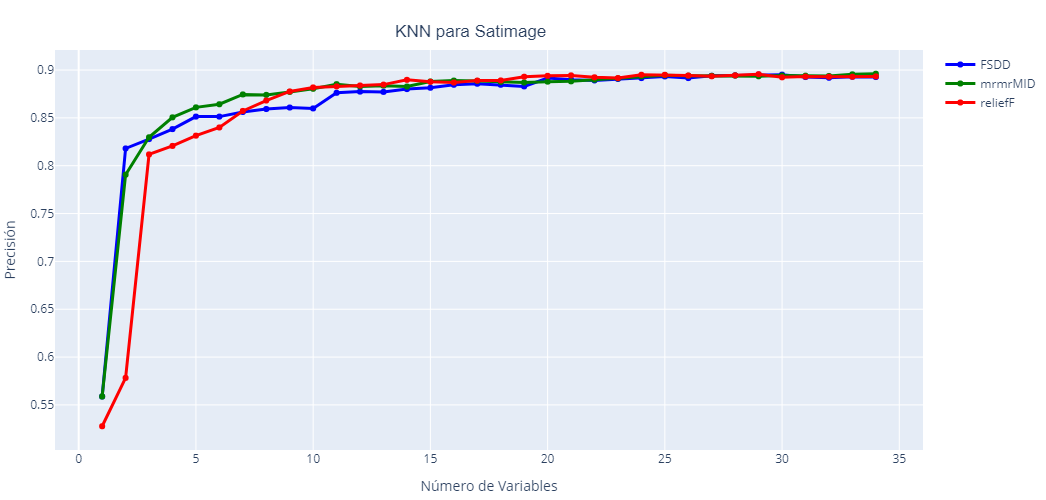

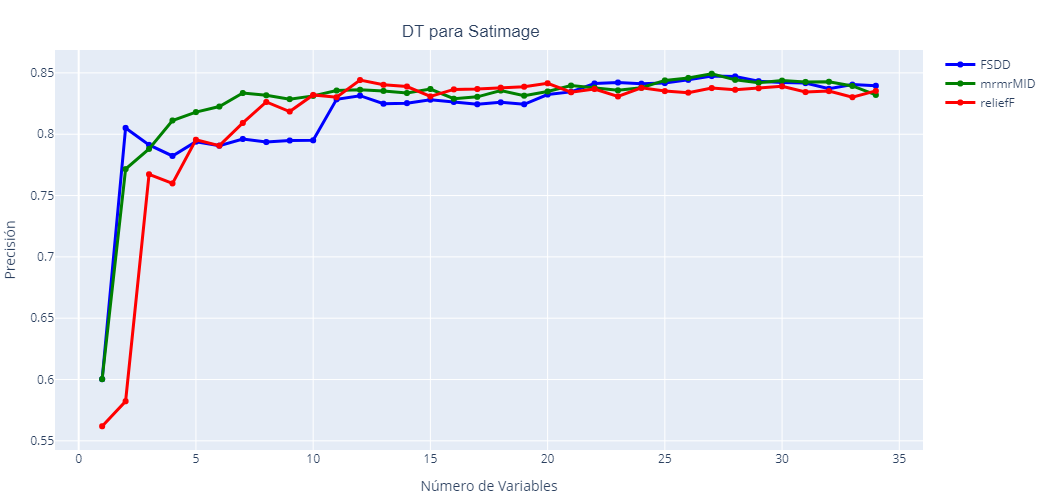

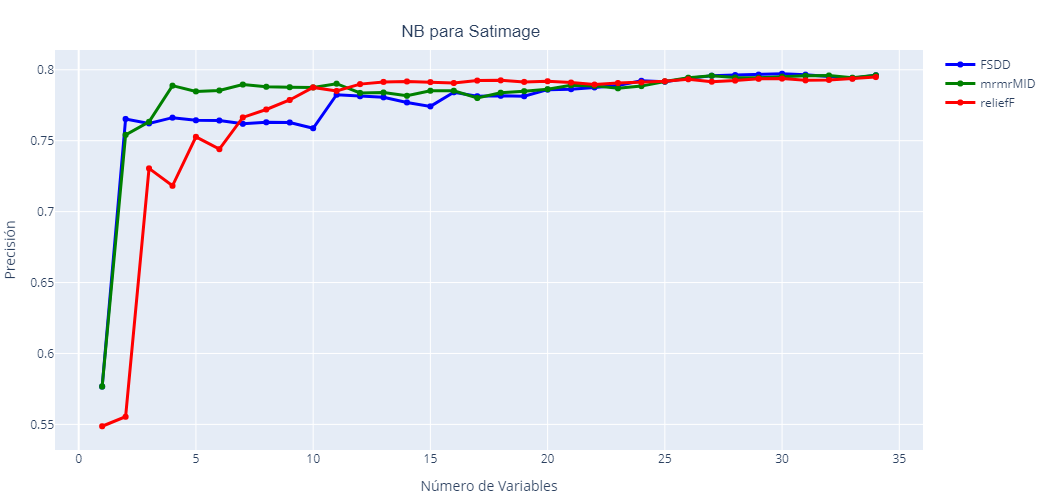

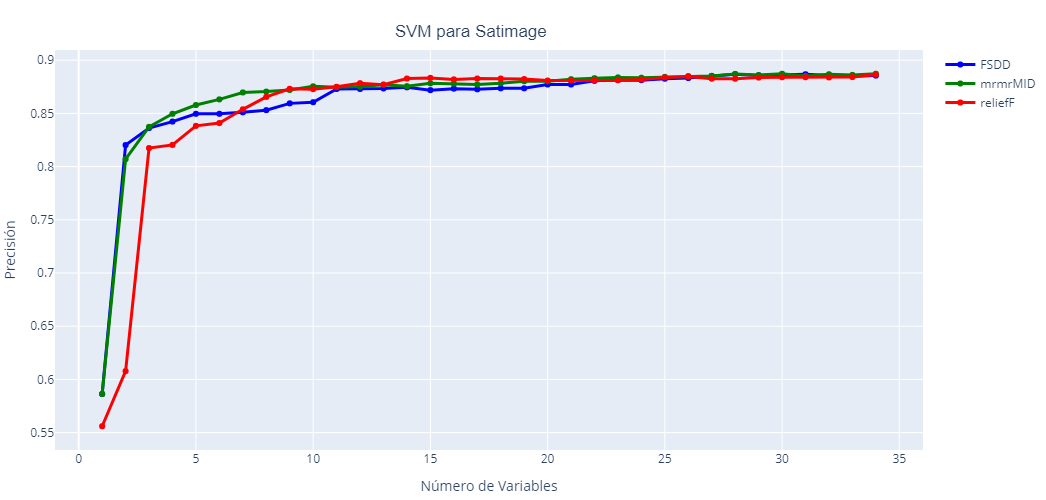

In [15]:
graph_KNN_satimage.show()
graph_DT_satimage.show()
graph_NB_satimage.show()
graph_SVM_satimage.show()

### Experimentos para mfeat

In [16]:
### Esto toma tiempo ###
start=time.time()
filtering_columns_fsdd=top_variables(mfeat,'class','fsdd',number_variables=50)
filtering_columns_mrmrMID=top_variables(mfeat,'class','mrmrMID',number_variables=50) 
filtering_columns_reliefF=top_variables(mfeat,'class','reliefF',number_variables=50) 
end=time.time()
print('Obtener los rankings de variables para mfeat tomó {} segundos'.format(end-start))

start=time.time()
### KNN para Mfeat ###
precisiones_fsdd_KNN_mfeat=[filter_classify(data_filtered=mfeat[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='KNN',cv_fold_number=2,k_knn=7) for i in range(1,50)]
precisiones_mrmrMID_KNN_mfeat=[filter_classify(data_filtered=mfeat[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='KNN',cv_fold_number=2,k_knn=7) for i in range(1,50)]
precisiones_reliefF_KNN_mfeat=[filter_classify(data_filtered=mfeat[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='KNN',cv_fold_number=2,k_knn=7) for i in range(1,50)]

### DT para Mfeat ###
precisiones_fsdd_DT_mfeat=[filter_classify(data_filtered=mfeat[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='DT',cv_fold_number=2,k_knn=7) for i in range(1,50)]
precisiones_mrmrMID_DT_mfeat=[filter_classify(data_filtered=mfeat[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='DT',cv_fold_number=2,k_knn=7) for i in range(1,50)]
precisiones_reliefF_DT_mfeat=[filter_classify(data_filtered=mfeat[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='DT',cv_fold_number=2,k_knn=7) for i in range(1,50)]

### NB para Mfeat ###
precisiones_fsdd_NB_mfeat=[filter_classify(data_filtered=mfeat[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='NB',cv_fold_number=2,k_knn=7) for i in range(1,50)]
precisiones_mrmrMID_NB_mfeat=[filter_classify(data_filtered=mfeat[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='NB',cv_fold_number=2,k_knn=7) for i in range(1,50)]
precisiones_reliefF_NB_mfeat=[filter_classify(data_filtered=mfeat[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='NB',cv_fold_number=2,k_knn=7) for i in range(1,50)]

### SVM para Mfeat ###
precisiones_fsdd_SVM_mfeat=[filter_classify(data_filtered=mfeat[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='SVM',cv_fold_number=2,k_knn=7) for i in range(1,50)]
precisiones_mrmrMID_SVM_mfeat=[filter_classify(data_filtered=mfeat[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='SVM',cv_fold_number=2,k_knn=7) for i in range(1,50)]
precisiones_reliefF_SVM_mfeat=[filter_classify(data_filtered=mfeat[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='SVM',cv_fold_number=2,k_knn=7) for i in range(1,50)]

end=time.time()
print('Ajustar todos los clasificadores para mfeat tomó {} segundos'.format(end-start))

### Voy a escribir estos resultados en un dataframe para leerlos en el archivo de la presentación y presentar el gráfico de plotly allí ###
resultados_Mfeat = pd.DataFrame({
    
    'Precisiones FSDD KNN': precisiones_fsdd_KNN_mfeat,
    'Precisiones mrmrMID KNN': precisiones_mrmrMID_KNN_mfeat,
    'Precisiones reliefF KNN': precisiones_reliefF_KNN_mfeat,

    'Precisiones FSDD DT': precisiones_fsdd_DT_mfeat,
    'Precisiones mrmrMID DT': precisiones_mrmrMID_DT_mfeat,
    'Precisiones reliefF DT': precisiones_reliefF_DT_mfeat,
    
    'Precisiones FSDD NB': precisiones_fsdd_NB_mfeat,
    'Precisiones mrmrMID NB': precisiones_mrmrMID_NB_mfeat,
    'Precisiones reliefF NB': precisiones_reliefF_NB_mfeat,
    
    'Precisiones FSDD SVM': precisiones_fsdd_SVM_mfeat,
    'Precisiones mrmrMID SVM': precisiones_mrmrMID_SVM_mfeat,
    'Precisiones reliefF SVM': precisiones_reliefF_SVM_mfeat,
})

resultados_Mfeat.to_csv('Resultados_Mfeat.csv')

Filtro de variables utilizando FSDD tomó 6.078920125961304 segundos
Filtro de variables utilizando mrmrMID tomó 1346.4135677814484 segundos
Filtro de variables utilizando reliefF tomó 1130.146404504776 segundos
Obtener los rankings de variables para mfeat tomó 2482.733615875244 segundos
Ajustar todos los clasificadores para mfeat tomó 190.89248156547546 segundos


#### Gráficos para mfeat 

In [17]:
resultados_Mfeat=pd.read_csv('Resultados_Mfeat.csv')

graph_KNN_mfeat= graph_precision(resultados_Mfeat, 'KNN', 'Mfeat')
graph_DT_mfeat= graph_precision(resultados_Mfeat, 'DT', 'Mfeat')
graph_NB_mfeat= graph_precision(resultados_Mfeat, 'NB', 'Mfeat')
graph_SVM_mfeat= graph_precision(resultados_Mfeat, 'SVM', 'Mfeat')

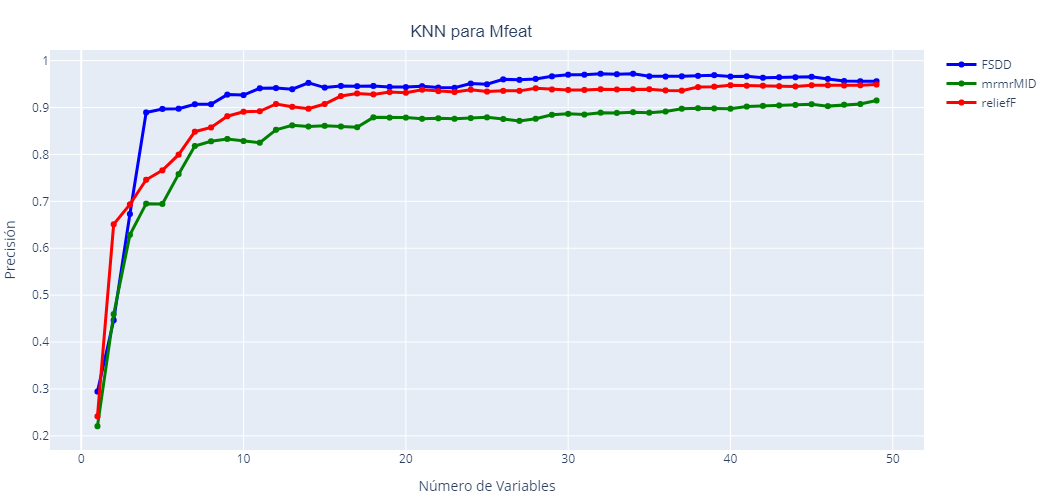

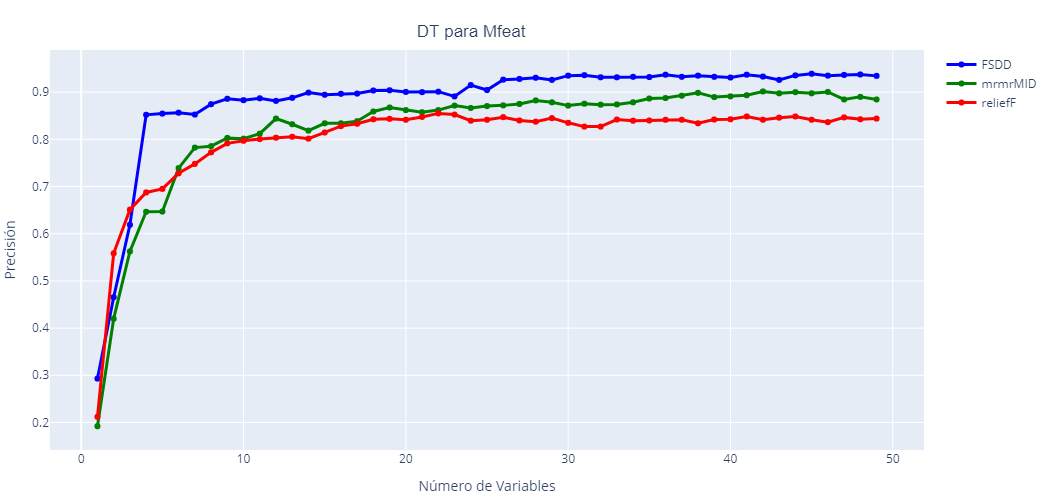

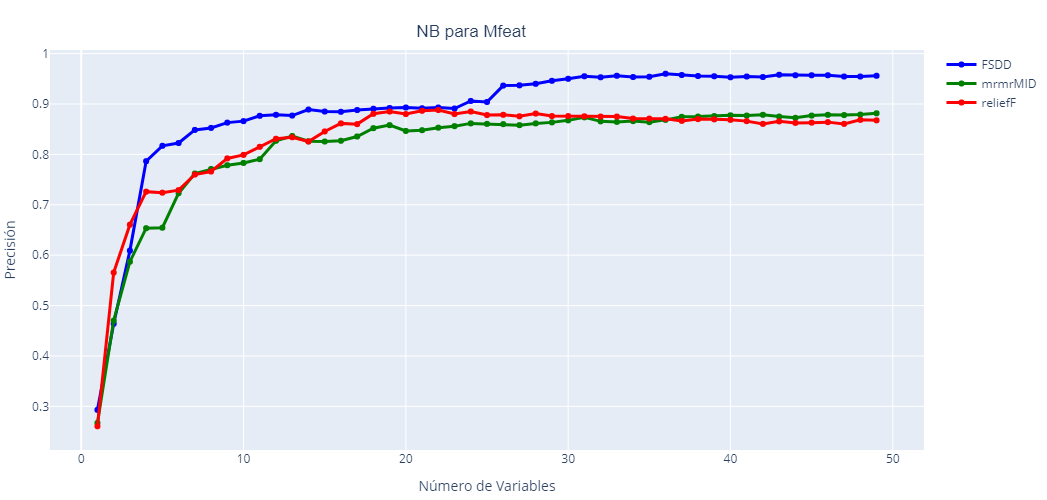

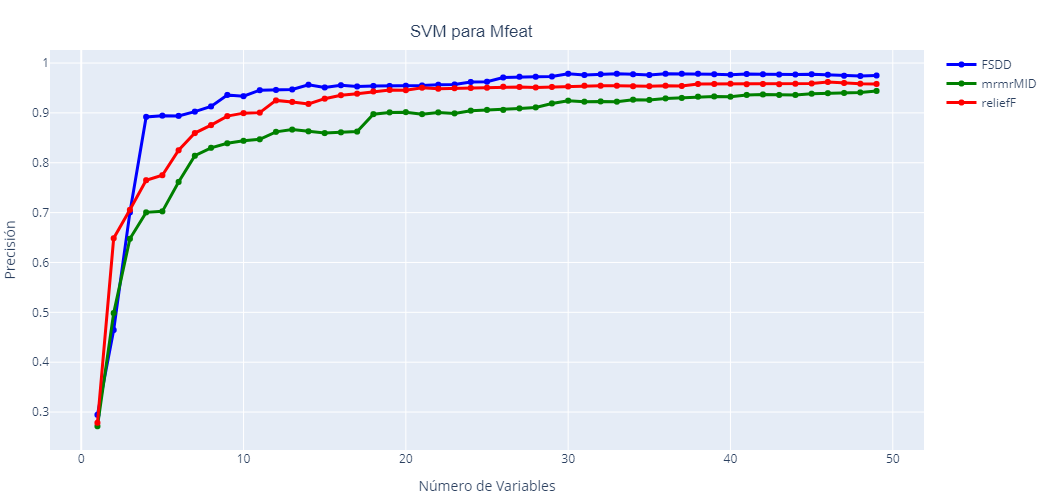

In [18]:
graph_KNN_mfeat.show()
graph_DT_mfeat.show()
graph_NB_mfeat.show()
graph_SVM_mfeat.show()

### Experimentos para Spambase

In [19]:
### Esto toma un rato ###
start=time.time()
filtering_columns_fsdd=top_variables(spambase,'class','fsdd',number_variables=55)
filtering_columns_mrmrMID=top_variables(spambase,'class','mrmrMID',number_variables=55)
filtering_columns_reliefF=top_variables(spambase,'class','reliefF',number_variables=55)
end=time.time()
print('Obtener los rankings de variables para spambase tomó {} segundos'.format(end-start))

start=time.time()
### KNN para Spambase ###
precisiones_fsdd_KNN_spambase=[filter_classify(data_filtered=spambase[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='KNN',cv_fold_number=2,k_knn=7) for i in range(1,55)]
precisiones_mrmrMID_KNN_spambase=[filter_classify(data_filtered=spambase[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='KNN',cv_fold_number=2,k_knn=7) for i in range(1,55)]
precisiones_reliefF_KNN_spambase=[filter_classify(data_filtered=spambase[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='KNN',cv_fold_number=2,k_knn=7) for i in range(1,55)]

### DT para Spambase ###
precisiones_fsdd_DT_spambase=[filter_classify(data_filtered=spambase[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='DT',cv_fold_number=2,k_knn=7) for i in range(1,55)]
precisiones_mrmrMID_DT_spambase=[filter_classify(data_filtered=spambase[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='DT',cv_fold_number=2,k_knn=7) for i in range(1,55)]
precisiones_reliefF_DT_spambase=[filter_classify(data_filtered=spambase[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='DT',cv_fold_number=2,k_knn=7) for i in range(1,55)]

### NB para Spambase ###
precisiones_fsdd_NB_spambase=[filter_classify(data_filtered=spambase[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='NB',cv_fold_number=2,k_knn=7) for i in range(1,55)]
precisiones_mrmrMID_NB_spambase=[filter_classify(data_filtered=spambase[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='NB',cv_fold_number=2,k_knn=7) for i in range(1,55)]
precisiones_reliefF_NB_spambase=[filter_classify(data_filtered=spambase[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='NB',cv_fold_number=2,k_knn=7) for i in range(1,55)]

### SVM para Spambase ###
precisiones_fsdd_SVM_spambase=[filter_classify(data_filtered=spambase[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='SVM',cv_fold_number=2,k_knn=7) for i in range(1,55)]
precisiones_mrmrMID_SVM_spambase=[filter_classify(data_filtered=spambase[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='SVM',cv_fold_number=2,k_knn=7) for i in range(1,55)]
precisiones_reliefF_SVM_spambase=[filter_classify(data_filtered=spambase[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='SVM',cv_fold_number=2,k_knn=7) for i in range(1,55)]

end=time.time()
print('Ajustar todos los clasificadores para spambase tomó {} segundos'.format(end-start))

### Voy a escribir estos resultados en un dataframe para leerlos en el archivo de la presentación y presentar el gráfico de plotly allí ###
resultados_Spambase = pd.DataFrame({
    
    'Precisiones FSDD KNN': precisiones_fsdd_KNN_spambase,
    'Precisiones mrmrMID KNN': precisiones_mrmrMID_KNN_spambase,
    'Precisiones reliefF KNN': precisiones_reliefF_KNN_spambase,

    'Precisiones FSDD DT': precisiones_fsdd_DT_spambase,
    'Precisiones mrmrMID DT': precisiones_mrmrMID_DT_spambase,
    'Precisiones reliefF DT': precisiones_reliefF_DT_spambase,
    
    'Precisiones FSDD NB': precisiones_fsdd_NB_spambase,
    'Precisiones mrmrMID NB': precisiones_mrmrMID_NB_spambase,
    'Precisiones reliefF NB': precisiones_reliefF_NB_spambase,
    
    'Precisiones FSDD SVM': precisiones_fsdd_SVM_spambase,
    'Precisiones mrmrMID SVM': precisiones_mrmrMID_SVM_spambase,
    'Precisiones reliefF SVM': precisiones_reliefF_SVM_spambase,
})

resultados_Spambase.to_csv('Resultados_Spambase.csv')

Filtro de variables utilizando FSDD tomó 0.8419189453125 segundos
Filtro de variables utilizando mrmrMID tomó 110.50802063941956 segundos
Filtro de variables utilizando reliefF tomó 339.8159122467041 segundos
Obtener los rankings de variables para spambase tomó 451.17574167251587 segundos
Ajustar todos los clasificadores para spambase tomó 798.5242280960083 segundos


#### Gráficos para spambase

In [20]:
resultados_Spambase=pd.read_csv('Resultados_Spambase.csv')

graph_KNN_Spambase= graph_precision(resultados_Spambase, 'KNN', 'Spambase')
graph_DT_Spambase= graph_precision(resultados_Spambase, 'DT', 'Spambase')
graph_NB_Spambase= graph_precision(resultados_Spambase, 'NB', 'Spambase')
graph_SVM_Spambase= graph_precision(resultados_Spambase, 'SVM', 'Spambase')

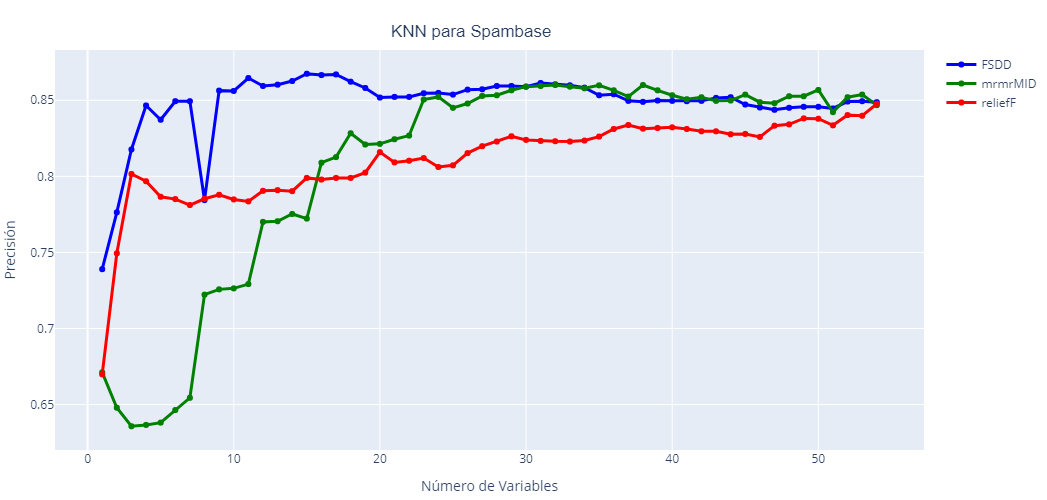

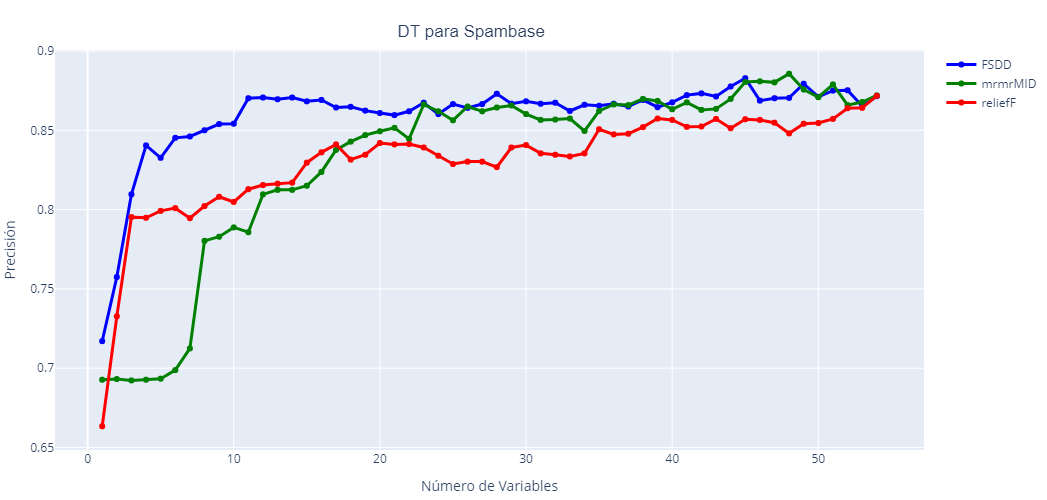

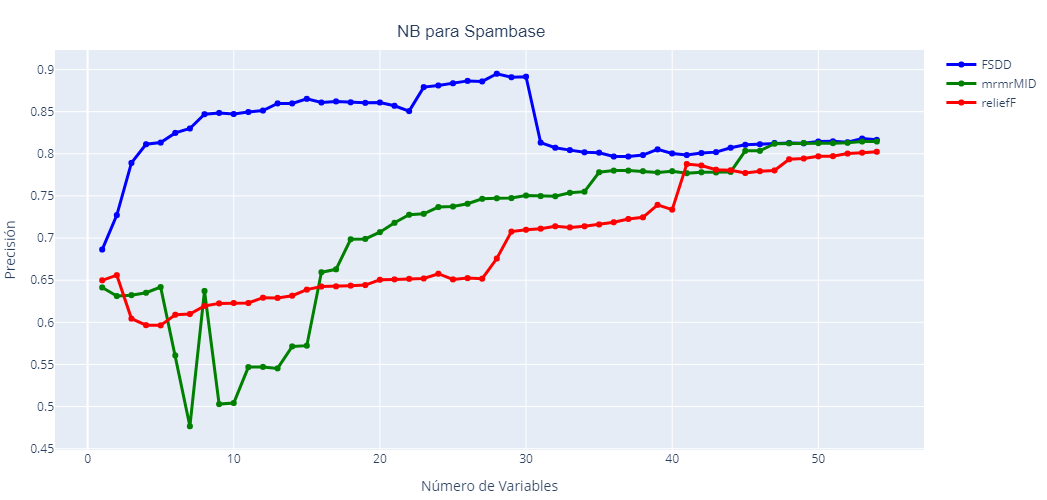

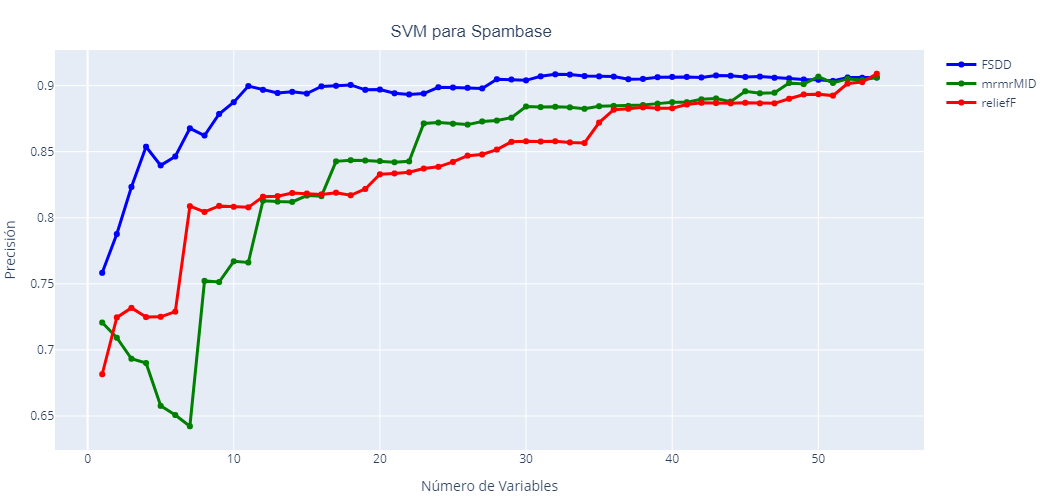

In [21]:
graph_KNN_Spambase.show()
graph_DT_Spambase.show()
graph_NB_Spambase.show()
graph_SVM_Spambase.show()

### Experimentos para Wine

In [27]:
### Esto toma tiempo ###
start=time.time()
filtering_columns_fsdd=top_variables(wine,'class','fsdd',number_variables=13) #En este ssólo necesitamos correrlo una vez
filtering_columns_mrmrMID=top_variables(wine,'class','mrmrMID',number_variables=13) #En este ssólo necesitamos correrlo una vez
filtering_columns_reliefF=top_variables(wine,'class','reliefF',number_variables=13) 
end=time.time()
print('Obtener los rankings de variables para wine tomó {} segundos'.format(end-start))

start=time.time()
### KNN para Mfeat ###
precisiones_fsdd_KNN_wine=[filter_classify(data_filtered=wine[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='KNN',cv_fold_number=2,k_knn=7) for i in range(1,14)]
precisiones_mrmrMID_KNN_wine=[filter_classify(data_filtered=wine[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='KNN',cv_fold_number=2,k_knn=7) for i in range(1,14)]
precisiones_reliefF_KNN_wine=[filter_classify(data_filtered=wine[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='KNN',cv_fold_number=2,k_knn=7) for i in range(1,14)]

### DT para Mfeat ###
precisiones_fsdd_DT_wine=[filter_classify(data_filtered=wine[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='DT',cv_fold_number=2,k_knn=7) for i in range(1,14)]
precisiones_mrmrMID_DT_wine=[filter_classify(data_filtered=wine[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='DT',cv_fold_number=2,k_knn=7) for i in range(1,14)]
precisiones_reliefF_DT_wine=[filter_classify(data_filtered=wine[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='DT',cv_fold_number=2,k_knn=7) for i in range(1,14)]

### NB para Mfeat ###
precisiones_fsdd_NB_wine=[filter_classify(data_filtered=wine[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='NB',cv_fold_number=2,k_knn=7) for i in range(1,14)]
precisiones_mrmrMID_NB_wine=[filter_classify(data_filtered=wine[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='NB',cv_fold_number=2,k_knn=7) for i in range(1,14)]
precisiones_reliefF_NB_wine=[filter_classify(data_filtered=wine[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='NB',cv_fold_number=2,k_knn=7) for i in range(1,14)]

### SVM para Mfeat ###
precisiones_fsdd_SVM_wine=[filter_classify(data_filtered=wine[filtering_columns_fsdd[0:i]+['class']],respname='class',classifier='SVM',cv_fold_number=2,k_knn=7) for i in range(1,14)]
precisiones_mrmrMID_SVM_wine=[filter_classify(data_filtered=wine[filtering_columns_mrmrMID[0:i]+['class']],respname='class',classifier='SVM',cv_fold_number=2,k_knn=7) for i in range(1,14)]
precisiones_reliefF_SVM_wine=[filter_classify(data_filtered=wine[filtering_columns_reliefF[0:i]+['class']],respname='class',classifier='SVM',cv_fold_number=2,k_knn=7) for i in range(1,14)]

end=time.time()
print('Ajustar todos los clasificadores para wine tomó {} segundos'.format(end-start))

### Voy a escribir estos resultados en un dataframe para leerlos en el archivo de la presentación y presentar el gráfico de plotly allí ###
resultados_Wine= pd.DataFrame({
    
    'Precisiones FSDD KNN': precisiones_fsdd_KNN_wine,
    'Precisiones mrmrMID KNN': precisiones_mrmrMID_KNN_wine,
    'Precisiones reliefF KNN': precisiones_reliefF_KNN_wine,

    'Precisiones FSDD DT': precisiones_fsdd_DT_wine,
    'Precisiones mrmrMID DT': precisiones_mrmrMID_DT_wine,
    'Precisiones reliefF DT': precisiones_reliefF_DT_wine,
    
    'Precisiones FSDD NB': precisiones_fsdd_NB_wine,
    'Precisiones mrmrMID NB': precisiones_mrmrMID_NB_wine,
    'Precisiones reliefF NB': precisiones_reliefF_NB_wine,
    
    'Precisiones FSDD SVM': precisiones_fsdd_SVM_wine,
    'Precisiones mrmrMID SVM': precisiones_mrmrMID_SVM_wine,
    'Precisiones reliefF SVM': precisiones_reliefF_SVM_wine,
})

resultados_Wine.to_csv('Resultados_wine.csv')

Filtro de variables utilizando FSDD tomó 0.013628482818603516 segundos
Filtro de variables utilizando mrmrMID tomó 0.9503276348114014 segundos
Filtro de variables utilizando reliefF tomó 6.2372283935546875 segundos
Obtener los rankings de variables para wine tomó 7.2092883586883545 segundos
Ajustar todos los clasificadores para wine tomó 5.000341415405273 segundos


#### Tabla para Wine

In [38]:
resultados_WineT= resultados_Wine.T
resultados_WineT

0         1         2         3         4   \
Precisiones FSDD KNN     0.797753  0.898876  0.932584  0.943820  0.955056   
Precisiones mrmrMID KNN  0.797753  0.719101  0.735955  0.803371  0.808989   
Precisiones reliefF KNN  0.528090  0.780899  0.803371  0.949438  0.966292   
Precisiones FSDD DT      0.752809  0.848315  0.814607  0.876404  0.949438   
Precisiones mrmrMID DT   0.752809  0.719101  0.735955  0.859551  0.853933   
Precisiones reliefF DT   0.511236  0.719101  0.764045  0.938202  0.949438   
Precisiones FSDD NB      0.786517  0.898876  0.910112  0.938202  0.943820   
Precisiones mrmrMID NB   0.786517  0.775281  0.831461  0.853933  0.893258   
Precisiones reliefF NB   0.567416  0.775281  0.825843  0.943820  0.960674   
Precisiones FSDD SVM     0.803371  0.893258  0.915730  0.949438  0.966292   
Precisiones mrmrMID SVM  0.803371  0.735955  0.808989  0.859551  0.904494   
Precisiones reliefF SVM  0.556180  0.780899  0.820225  0.938202  0.955056   

                               5         6         7         8         9   \
Precisiones FSDD KNN     0.960674  0.955056  0.943820  0.943820  0.949438   
Precisiones mrmrMID KNN  0.803371  0.786517  0.803371  0.808989  0.904494   
Precisiones reliefF KNN  0.943820  0.921348  0.915730  0.932584  0.910112   
Precisiones FSDD DT      0.932584  0.932584  0.938202  0.938202  0.915730   
Precisiones mrmrMID DT   0.820225  0.842697  0.831461  0.808989  0.887640   
Precisiones reliefF DT   0.943820  0.943820  0.949438  0.938202  0.915730   
Precisiones FSDD NB      0.966292  0.960674  0.966292  0.971910  0.971910   
Precisiones mrmrMID NB   0.876404  0.870787  0.893258  0.915730  0.938202   
Precisiones reliefF NB   0.943820  0.932584  0.926966  0.938202  0.938202   
Precisiones FSDD SVM     0.971910  0.971910  0.971910  0.977528  0.971910   
Precisiones mrmrMID SVM  0.893258  0.870787  0.915730  0.932584  0.955056   
Precisiones reliefF SVM  0.949438  0.949438  0.955056  0.943820  0.955056   

                               10        11        12  
Precisiones FSDD KNN     0.960674  0.943820  0.938202  
Precisiones mrmrMID KNN  0.926966  0.943820  0.938202  
Precisiones reliefF KNN  0.926966  0.910112  0.938202  
Precisiones FSDD DT      0.932584  0.926966  0.921348  
Precisiones mrmrMID DT   0.898876  0.910112  0.904494  
Precisiones reliefF DT   0.921348  0.915730  0.915730  
Precisiones FSDD NB      0.966292  0.971910  0.977528  
Precisiones mrmrMID NB   0.971910  0.983146  0.977528  
Precisiones reliefF NB   0.949438  0.949438  0.977528  
Precisiones FSDD SVM     0.966292  0.977528  0.977528  
Precisiones mrmrMID SVM  0.971910  0.988764  0.977528  
Precisiones reliefF SVM  0.960674  0.943820  0.977528

El mismo proceso se puede seguir para los otros conjuntos de datos, o para nuevos!

J.J.C.M.

----------------------------------------------------------------------------------------------------------------